In [1]:
#pip install pyodbc
#pip install sqlachemy
#pip install pandas
#pip install networkx

In [2]:
import pandas as pd
import pyodbc
from sqlalchemy import create_engine

user = 'admin'
password = 'admin'
host = 'localhost\SQLEXPRESS'
database = 'AdventureWorks2019'

engine = create_engine(
    'mssql+pyodbc://'
    f'{user}:{password}@{host}/{database}?' # username:pwd@server:port/database
    'TrustServerCertificate=yes&'
    'driver=ODBC+Driver+17+for+SQL+Server'
    )

test = pd.read_sql("select * from INFORMATION_SCHEMA.TABLES", engine)
test.head(10)

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,AdventureWorks2019,Sales,SalesTaxRate,BASE TABLE
1,AdventureWorks2019,Sales,PersonCreditCard,BASE TABLE
2,AdventureWorks2019,Person,vAdditionalContactInfo,VIEW
3,AdventureWorks2019,Person,PersonPhone,BASE TABLE
4,AdventureWorks2019,HumanResources,vEmployee,VIEW
5,AdventureWorks2019,Sales,SalesTerritory,BASE TABLE
6,AdventureWorks2019,HumanResources,vEmployeeDepartment,VIEW
7,AdventureWorks2019,Person,PhoneNumberType,BASE TABLE
8,AdventureWorks2019,HumanResources,vEmployeeDepartmentHistory,VIEW
9,AdventureWorks2019,Sales,vIndividualCustomer,VIEW


### Table Information

Let's get some information about the tables

In [3]:
tbl_list = pd.read_sql("select * from [sys].[tables] o where o.type = 'u'", engine)
tbl_list.head()

,name,object_id,principal_id,schema_id,parent_object_id,type,type_desc,create_date,modify_date,is_ms_shipped,...,history_retention_period_unit_desc,is_node,is_edge,data_retention_period,data_retention_period_unit,data_retention_period_unit_desc,ledger_type,ledger_type_desc,ledger_view_id,is_dropped_ledger_table
0,SalesTaxRate,30623152,None,9,0,U,USER_TABLE,2023-05-08 12:07:29.573,2023-05-08 12:07:39.243,False,...,None,False,False,-1,-1,INFINITE,0,NON_LEDGER_TABLE,None,False
1,PersonCreditCard,66099276,None,9,0,U,USER_TABLE,2023-05-08 12:07:29.480,2023-05-08 12:07:38.723,False,...,None,False,False,-1,-1,INFINITE,0,NON_LEDGER_TABLE,None,False
2,PersonPhone,98099390,None,6,0,U,USER_TABLE,2023-05-08 12:07:29.483,2023-05-08 12:07:38.753,False,...,None,False,False,-1,-1,INFINITE,0,NON_LEDGER_TABLE,None,False
3,SalesTerritory,110623437,None,9,0,U,USER_TABLE,2023-05-08 12:07:29.580,2023-05-08 12:07:39.270,False,...,None,False,False,-1,-1,INFINITE,0,NON_LEDGER_TABLE,None,False
4,PhoneNumberType,130099504,None,6,0,U,USER_TABLE,2023-05-08 12:07:29.487,2023-05-08 12:07:38.753,False,...,None,False,False,-1,-1,INFINITE,0,NON_LEDGER_TABLE,None,False


Let's count table sizes

In [4]:
tbl_sizes = pd.read_sql("""
select o.object_id, sum(p.Rows) AS [row_count]
from sys.objects as o 
join sys.partitions as p on o.object_id = p.object_id
where o.type = 'U' and o.is_ms_shipped = 0x0 and index_id < 2 -- 0:Heap, 1:Clustered
group by o.object_id""", engine)
tbl_sizes.head()

,object_id,row_count
0,30623152,29
1,66099276,19118
2,98099390,19972
3,110623437,10
4,130099504,3


In [5]:
tbl_exp = pd.concat([tbl_list, tbl_sizes], axis=1, join="inner")
tbl_exp.head()

,name,object_id,principal_id,schema_id,parent_object_id,type,type_desc,create_date,modify_date,is_ms_shipped,...,is_edge,data_retention_period,data_retention_period_unit,data_retention_period_unit_desc,ledger_type,ledger_type_desc,ledger_view_id,is_dropped_ledger_table,object_id,row_count
0,SalesTaxRate,30623152,None,9,0,U,USER_TABLE,2023-05-08 12:07:29.573,2023-05-08 12:07:39.243,False,...,False,-1,-1,INFINITE,0,NON_LEDGER_TABLE,None,False,30623152,29
1,PersonCreditCard,66099276,None,9,0,U,USER_TABLE,2023-05-08 12:07:29.480,2023-05-08 12:07:38.723,False,...,False,-1,-1,INFINITE,0,NON_LEDGER_TABLE,None,False,66099276,19118
2,PersonPhone,98099390,None,6,0,U,USER_TABLE,2023-05-08 12:07:29.483,2023-05-08 12:07:38.753,False,...,False,-1,-1,INFINITE,0,NON_LEDGER_TABLE,None,False,98099390,19972
3,SalesTerritory,110623437,None,9,0,U,USER_TABLE,2023-05-08 12:07:29.580,2023-05-08 12:07:39.270,False,...,False,-1,-1,INFINITE,0,NON_LEDGER_TABLE,None,False,110623437,10
4,PhoneNumberType,130099504,None,6,0,U,USER_TABLE,2023-05-08 12:07:29.487,2023-05-08 12:07:38.753,False,...,False,-1,-1,INFINITE,0,NON_LEDGER_TABLE,None,False,130099504,3


### Column Information
Let's retrieve some core information about the table columns

In [6]:
col_info = pd.read_sql(
      """select id = row_number() over (order by o.schema_id, o.object_id, c.column_id),
        o.schema_id, 
        schema_name = schema_name(o.schema_id), 
        table_id = o.object_id, 
        table_name = o.name, 
        column_id = c.column_id,
        table_column_id = cast(o.object_id as varchar(10)) + '-' + cast(c.column_id as varchar(10)),  
        column_name = c.name,
        c.system_type_id,
        system_type_name = type_name(c.system_type_id),
        c.user_type_id,
        user_type_name = type_name(c.user_type_id),
        c.max_length,
        c.default_object_id,
        default_object_name = object_name(c.default_object_id),

        --c.is_column_set,
        --c.rule_object_id,
        
        c.is_computed,
        c.is_identity,
        c.is_filestream,
        c.is_hidden,
        c.is_masked,
        c.is_nullable,
        c.is_rowguidcol


        
      from sys.all_columns c
      join sys.all_objects o on c.object_id = o.object_id
      where o.type = 'U' and schema_name(o.schema_id) not in ('sys','dbo')""",
  engine)

col_info.head(20)

,id,schema_id,schema_name,table_id,table_name,column_id,table_column_id,column_name,system_type_id,system_type_name,...,max_length,default_object_id,default_object_name,is_computed,is_identity,is_filestream,is_hidden,is_masked,is_nullable,is_rowguidcol
0,1,5,HumanResources,382624406,Shift,1,382624406-1,ShiftID,48,tinyint,...,1,0,None,False,True,False,False,False,False,False
1,2,5,HumanResources,382624406,Shift,2,382624406-2,Name,231,nvarchar,...,100,0,None,False,False,False,False,False,False,False
2,3,5,HumanResources,382624406,Shift,3,382624406-3,StartTime,41,time,...,5,0,None,False,False,False,False,False,False,False
3,4,5,HumanResources,382624406,Shift,4,382624406-4,EndTime,41,time,...,5,0,None,False,False,False,False,False,False,False
4,5,5,HumanResources,382624406,Shift,5,382624406-5,ModifiedDate,61,datetime,...,8,398624463,DF_Shift_ModifiedDate,False,False,False,False,False,False,False
5,6,5,HumanResources,1381579960,Department,1,1381579960-1,DepartmentID,52,smallint,...,2,0,None,False,True,False,False,False,False,False
6,7,5,HumanResources,1381579960,Department,2,1381579960-2,Name,231,nvarchar,...,100,0,None,False,False,False,False,False,False,False
7,8,5,HumanResources,1381579960,Department,3,1381579960-3,GroupName,231,nvarchar,...,100,0,None,False,False,False,False,False,False,False
8,9,5,HumanResources,1381579960,Department,4,1381579960-4,ModifiedDate,61,datetime,...,8,1397580017,DF_Department_ModifiedDate,False,False,False,False,False,False,False
9,10,5,HumanResources,1573580644,Employee,1,1573580644-1,BusinessEntityID,56,int,...,4,0,None,False,False,False,False,False,False,False


let's count different stats for the columns

In [7]:
col_info.count()

id                     465
schema_id              465
schema_name            465
table_id               465
table_name             465
column_id              465
table_column_id        465
column_name            465
system_type_id         465
system_type_name       461
user_type_id           465
user_type_name         465
max_length             465
default_object_id      465
default_object_name    150
is_computed            465
is_identity            465
is_filestream          465
is_hidden              465
is_masked              465
is_nullable            465
is_rowguidcol          465
dtype: int64

#### Tables columns and primary keys

In [8]:
qry = """
    select 
    [table_id] = c1.object_id, 
    [schema_name] = schema_name(t.schema_id), 
    [table_name] = t.name,  
    [column_name] = c1.name, 
    [primary_key_name] = keycol.name 
    from sys.columns c1
    outer apply (
        select name from sys.columns c2 
        where c1.object_id = c2.object_id and c2.is_identity = 1
    ) keycol
    join sys.tables t on c1.object_id = t.object_id
"""

tcols = pd.read_sql(qry, engine)
tcols.head(20)

,table_id,schema_name,table_name,column_name,primary_key_name
0,30623152,Sales,SalesTaxRate,ModifiedDate,SalesTaxRateID
1,30623152,Sales,SalesTaxRate,Name,SalesTaxRateID
2,30623152,Sales,SalesTaxRate,rowguid,SalesTaxRateID
3,30623152,Sales,SalesTaxRate,SalesTaxRateID,SalesTaxRateID
4,30623152,Sales,SalesTaxRate,StateProvinceID,SalesTaxRateID
5,30623152,Sales,SalesTaxRate,TaxRate,SalesTaxRateID
6,30623152,Sales,SalesTaxRate,TaxType,SalesTaxRateID
7,66099276,Sales,PersonCreditCard,BusinessEntityID,None
8,66099276,Sales,PersonCreditCard,CreditCardID,None
9,66099276,Sales,PersonCreditCard,ModifiedDate,None


### Inspect Graphs

Prepare imports and setup diagram size

In [9]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [20, 12]

#### Checking possibibility to analyse other type of graph - column depdendencies.

##### Check Employee dependencies

TODO: add more depdendencies, such FK, PK, Default, Check, Trigger...

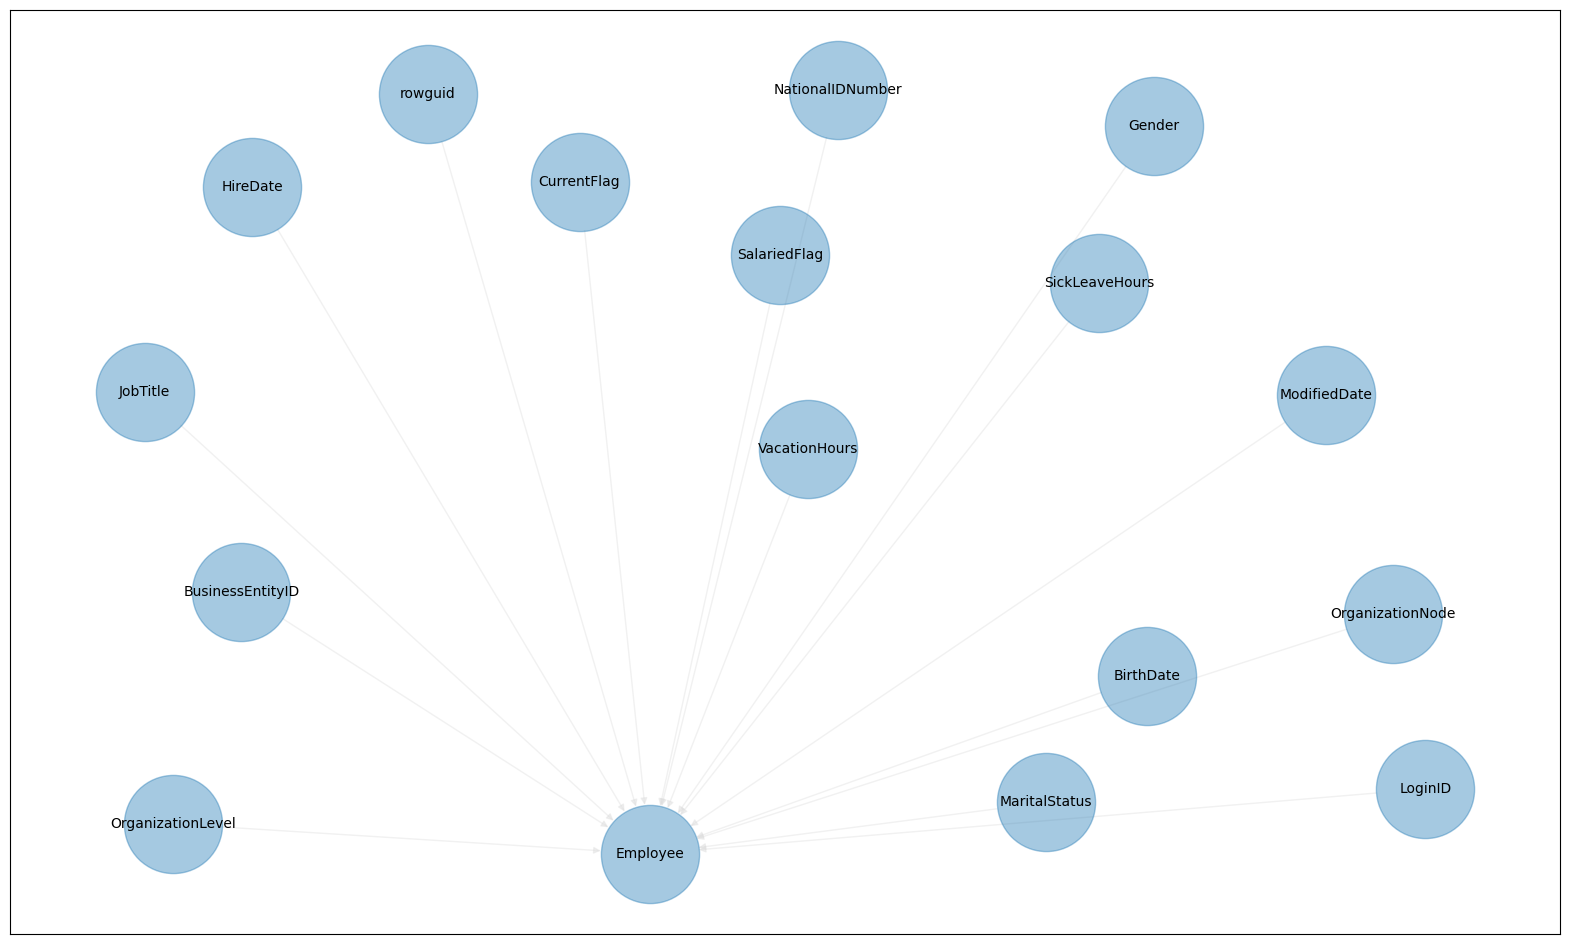

In [10]:
G = nx.DiGraph()
G = nx.from_pandas_edgelist(col_info[col_info["table_name"]=="Employee"], 
                            source="column_name", 
                            target="table_name", 
                            create_using=G)
pos = nx.spring_layout(G)


nx.draw_networkx(
    G,
    pos=pos,
    with_labels=False,
    #node_color=5,
    node_size=5000,
    edge_color="gainsboro",
    alpha=0.4,
)

nx.draw_networkx_labels(G, pos, font_size=10)
plt.show()

### Node-level Task Types

#### TODO ...

### Edge-level Task Types

#### TODO ...

### Graph-level Task Types

#### TODO ...
